In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers

2024-07-26 17:40:21.051845: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-26 17:40:21.375155: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-26 17:40:22.057364: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
#Coletando dados

df = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Moluscos/RJ_Reconstrucao_Moluscos_2024_06_25.xlsx')
df_desagregar = pd.DataFrame(df[['Ano','Lula_art','Lula_ind','Lula_art_ind','Polvo_art','Polvo_ind','Polvo_art_ind','Ostra_art','Mexilhao_art','TOTAL_MOLLUSCS']])

#Juntando valores de art e ind em art_ind(quando os 2 estão presentes) 
  #Lulas
for i in range(len(df_desagregar['Ano'])):
  if pd.isnull(df_desagregar.iloc[i,3])==True and pd.isnull(df_desagregar.iloc[i,2])==False and pd.isnull(df_desagregar.iloc[i,1])==False:
    df_desagregar.iloc[i,3] = df_desagregar.iloc[i,2] + df_desagregar.iloc[i,1] 

  #Polvos
for i in range(len(df_desagregar['Ano'])):
  if pd.isnull(df_desagregar.iloc[i,6])==True and pd.isnull(df_desagregar.iloc[i,5])==False and pd.isnull(df_desagregar.iloc[i,4])==False:
    df_desagregar.iloc[i,6] = df_desagregar.iloc[i,5] + df_desagregar.iloc[i,4] 


dados = df_desagregar[['Ano','Lula_art_ind','Polvo_art_ind','Ostra_art','Mexilhao_art']].dropna().reset_index(drop=True)

for i in range(len(dados['Ano'])):
  dados.loc[i,'Soma'] = dados.loc[i,'Lula_art_ind']+dados.loc[i, 'Polvo_art_ind']+dados.loc[i,'Ostra_art']+dados.loc[i,'Mexilhao_art']
  
dados = dados[['Ano','Lula_art_ind','Soma']]

#Fazendo as proporções
for i in range(len(dados['Ano'])):
  dados.loc[i,'Prop_Lula'] = dados.loc[i,'Lula_art_ind'] / dados.loc[i,'Soma']


anos_com_dados = dados["Ano"].values
anos_para_prever = np.array([1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1965,1969,1970,1971,1972,1973,1974,1975,1976,1977])
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()


prop = dados['Prop_Lula'].values
dados.head()

,Ano,Lula_art_ind,Soma,Prop_Lula
0,1962,22.0,29.0,0.758621
1,1963,57.0,135.0,0.422222
2,1964,71.0,708.0,0.100282
3,1966,21.0,75.0,0.280000
4,1984,296.0,344.0,0.860465


In [5]:
#Normalização dos dados

ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)
anos_para_prever_norm = (anos_para_prever - ano_mean)/ano_std
anos_com_dados_norm = (anos_com_dados - ano_mean)/ano_std

prop_mean = np.mean(prop)
prop_std = np.std(prop)
prop_norm = (prop - prop_mean)/prop_std

In [11]:
#Fit do modelo e salvando seus pesos
model = keras.Sequential([layers.Dense(96,activation='leaky_relu',input_shape=(1,)),
                             layers.Dense(32,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(96,activation='leaky_relu'),
                             layers.Dense(112,activation='leaky_relu'),
                             layers.Dense(1,activation='linear')])

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')


history = model.fit(anos_com_dados_norm,prop_norm, epochs=150, verbose=1)
model.save_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Moluscos/Lulas/pesos prop lulas/.weights.h5', overwrite=True)

Epoch 1/150


/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step - loss: 1.0067
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9936
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9850
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9771
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9679
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9576
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9464
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9335
Epoch 9/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9193
Epoch 10/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9040
Epoch 11/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8880
Epoch 12/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8720
Epoch 13/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8574
Epoch 14/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8453
Epoch 15/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8367
Epoch 16/150
1/1 ━━━━━━━━━━━━━

In [7]:
model.load_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Moluscos/Lulas/pesos prop lulas/.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Previsões dos dados ausentes: [[0.70873904]
 [0.69194126]
 [0.67393565]
 [0.65593016]
 [0.63792515]
 [0.61991906]
 [0.6019137 ]
 [0.58390784]
 [0.5659018 ]
 [0.5478964 ]
 [0.52989095]
 [0.51186866]
 [0.43977752]
 [0.39891887]
 [0.40171808]
 [0.406979  ]
 [0.41818613]
 [0.43072838]
 [0.44525063]
 [0.46181628]
 [0.48131147]
 [0.50440097]]


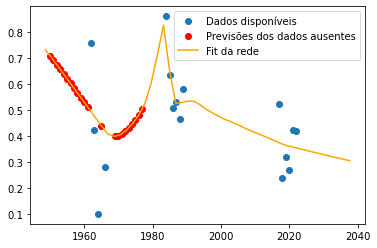

In [12]:
#Previsões
prev_disponiveis = model.predict(anos_com_dados_norm)*prop_std + prop_mean
prev_ausentes = model.predict(anos_para_prever_norm)*prop_std + prop_mean

#Colocando valores negativos para 0
for i in range(len(prev_ausentes)):
    if prev_ausentes[i]<0:
        prev_ausentes[i]=0
    if prev_ausentes[i]>=1:
        prev_ausentes[i]=1

#Plot dos dados e previsões
f1=plt.figure(1).add_subplot()
f1.scatter(anos_com_dados,prop,label='Dados disponíveis')
f1.scatter(anos_para_prever,prev_ausentes, color='red', label='Previsões dos dados ausentes')

#Plot do fit da rede
p = np.linspace(-2,2,50)
y = model.predict(p)*prop_std + prop_mean
f1.plot(p*ano_std + ano_mean,y,color='orange',label='Fit da rede')

#Print das previsões
print('Previsões dos dados ausentes:', prev_ausentes)


plt.legend()
plt.show()

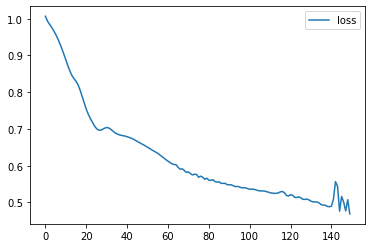

In [13]:
loss = history.history['loss']
plt.plot(loss,label='loss')
plt.legend()
plt.show()

In [26]:
#Lista todos_anos normalizada e sua predição num dataframe       (para poder me referir por indices)

anos = np.arange(1950,np.max(anos_para_prever)+1)
anos_norm = (anos-ano_mean)/ano_std
prev_continua = model.predict(anos_norm)*prop_std + prop_mean

for i in range(len(prev_continua)):
    if prev_continua[i]<0:
        prev_continua[i]=0
    if prev_continua[i]>=1:
        prev_continua[i]=1


df_previsoes = pd.DataFrame({'Ano':anos,'Prop_Lula':prev_continua.flatten()})


#Dataframe de valores de pesca baseando-se nas previsões de TOTAL_MOLLUSCS
TOTAL_MOLLUSCS_preenchido = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Moluscos/Previsão TOTAL_MOLLUSCS.xlsx')

for i in range(len(df_previsoes['Ano'])):
   df_previsoes.iloc[i,1] = float(df_previsoes.iloc[i,1])*float(TOTAL_MOLLUSCS_preenchido.iloc[i,2])



#Planilha com os dados preenchidos
df_preenchido = df[['Ano','Lula_art_ind']]

for i in range(len(df_previsoes['Ano'])):
        df_preenchido.iloc[i,1] = df_previsoes.iloc[i,1]

with pd.option_context('display.max_rows', None,):
    print(df_preenchido)

df_preenchido.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Moluscos/Lulas/Previsão Lula_art_ind_1950-1977.xlsx')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     Ano  Lula_art_ind
0   1950     24.291551
1   1951     27.701364
2   1952     30.609117
3   1953     30.156453
4   1954     26.753317
5   1955     22.687963
6   1956     26.285571
7   1957     37.370102
8   1958     24.899680
9   1959     12.601617
10  1960     22.785311
11  1961     18.427272
12  1962     18.766150
13  1963     67.091070
14  1964    324.122696
15  1965    246.275413
16  1966     31.631602
17  1967     58.948089
18  1968    335.835153
19  1969     49.864858
20  1970    111.275908
21  1971     54.128206
22  1972    100.782857
23  1973    226.563126
24  1974    313.456444
25  1975    109.912275
26  1976     49.575081
27  1977    147.285083
28  1978           NaN
29  1979           NaN
30  1980           NaN
31  1981           NaN
32  1982           NaN
33  1983           NaN
34  1984           NaN
35  1985           NaN
36  1986           NaN
37  1987           NaN
38  1988           NaN
39  1989           NaN
40  1990           

/tmp/ipykernel_6047/2305579578.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '24.29155051043926' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df_previsoes.iloc[i,1] = float(df_previsoes.iloc[i,1])*float(TOTAL_MOLLUSCS_preenchido.iloc[i,2])


In [24]:
#Planilha de TOTAL_MOLLUSCS sem Lula_art_ind
TOTAL_MOLLUSCS_sem_lu = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Moluscos/Previsão TOTAL_MOLLUSCS.xlsx')
for i in range(len(prev_continua)):
    if i+1950 in anos_para_prever:
        TOTAL_MOLLUSCS_sem_lu.loc[i,'TOTAL_MOLLUSCS'] -= df_previsoes.iloc[i,1]
        
TOTAL_MOLLUSCS_sem_lu.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Moluscos/Lulas/TOTAL_MOLLUSCS_sem_lu.xlsx')
TOTAL_MOLLUSCS_sem_lu

,Unnamed: 0,Ano,TOTAL_MOLLUSCS
0,0,1950,9.982772
1,1,1951,12.332907
2,2,1952,14.809340
3,3,1953,15.818644
4,4,1954,15.184702
5,5,1955,13.910304
6,6,1956,17.384429
7,7,1957,26.629898
8,8,1958,19.100320
9,9,1959,10.398383
